## Prepare os Dados

### Abra os arquivos e estude os dados.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

In [2]:
df_gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
df_gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
df_gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
# Como queremos saber prever os valores de rougher.output.recovery e final.output.recovery, 
# as linhas onde ambas as colunas são nulas não nos interessam.
# as outras colunas podem ter valores nulos pois podem não fazer parte de algum tipo de processo.

df_gold_recovery_train = df_gold_recovery_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
df_gold_recovery_train['final.output.recovery'].isna().sum()

0

### Verifique se a quantidade retirada foi calculada corretamente. Usando o conjunto de treinamento, calcule a quantidade retirada para a característica rougher.output.recovery. Encontre o EAM entre seus cálculos e os valores das características. Forneça resultados.

In [7]:
df_gold_recovery_train['rougher.output.concentrate_au'].fillna(df_gold_recovery_train['rougher.output.concentrate_au'].median(), inplace=True)
df_gold_recovery_train['final.output.concentrate_au'].fillna(df_gold_recovery_train['final.output.concentrate_au'].median(), inplace=True)
df_gold_recovery_train['rougher.output.tail_au'].fillna(df_gold_recovery_train['rougher.output.tail_au'].median(), inplace=True)

print(df_gold_recovery_train['rougher.output.concentrate_au'].isna().sum())
print('-------------------')
print(df_gold_recovery_train['final.output.concentrate_au'].isna().sum())
print('-------------------')
print(df_gold_recovery_train['rougher.output.tail_au'].isna().sum())

0
-------------------
0
-------------------
0


In [8]:
# Calcular o erro médio do calculo com a coluna rougher.output.recovery

r_cols = [col for col in df_gold_recovery_train.columns if 'rougher.output' in col]
df_t_sum = df_gold_recovery_train[r_cols]
r_cols.remove('rougher.output.recovery')
df_t_sum['sum'] = df_t_sum[r_cols].sum(axis=1)
df_t_sum[['rougher.output.recovery', 'sum']]
mean_absolute_error(df_t_sum['sum'], df_t_sum['rougher.output.recovery'])

/tmp/ipykernel_43/1074618453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_sum['sum'] = df_t_sum[r_cols].sum(axis=1)


12.65469814908878

Ao usar a soma das características e comparar com a coluna 'rougher.output.recovery' temos um erro médio de 12.65%.

### Analise as características não disponíveis no conjunto de teste. Quais são esses parâmetros? Qual é o tipo deles?

In [9]:
# Verificando as colunas que estão no conjunto de treino, mas não estão no de teste
set(df_gold_recovery_train.columns).difference(df_gold_recovery_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

As colunas presentes em gold_recovery_train são colunas que possuem as saídas de cada fase, essas características podem causar data leak no modelo.

### Faça o pré-processamento de dados.

In [10]:
# Verifica quais colunas são comuns aos conjuntos de treino e de teste

l_cols = []

for col in df_gold_recovery_train:
    if col in df_gold_recovery_test:
        l_cols.append(col)
        
len(l_cols)

53

In [11]:
# Treina um imputer para não ter diferença entre o preeenchimento dos dados nulos no conjunto de treino e de teste

impute = SimpleImputer(strategy='median')
X = impute.fit_transform(df_gold_recovery_train.loc[:, l_cols[1:]])

df_pp = pd.concat([df_gold_recovery_train['date'], pd.DataFrame(X)], axis=1)
df_pp.columns = df_gold_recovery_train.loc[:, l_cols].columns
df_pp.isna().sum().sum()

120522

In [12]:
# Preenche os dados no conjunto de teste

X = impute.transform(df_gold_recovery_test.iloc[:, 1:])

df_test_pp = pd.concat([df_gold_recovery_test['date'], pd.DataFrame(X)], axis=1)
df_test_pp.columns = df_gold_recovery_test.loc[:, l_cols].columns
df_test_pp.isna().sum().sum()

0

## Analise os dados

### Observe como a concentração de metais (Au, Ag, Pb) muda dependendo do estágio de purificação.

In [13]:
# Estágios Feed = Inicial, Rougher = Flotação, primary_cleaner = Purificação Primária, 
# secondary_cleaner = purificação secundária, final = característica finais

def build_metal_concentration_boxplot(df, metal):
    metals = {'au':'Ouro', 'ag':'Prata', 'pb':'Chumbo'}
    cols = ['rougher.input.feed_', 'rougher.output.concentrate_',
              'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
    cols = [col + metal for col in cols]
    fig, ax = plt.subplots(figsize =(7, 5))
    plt.boxplot(df[cols])
    ticks, labels = plt.xticks()
    m = metals.get(metal)
    str = 'Concentração de ' + m
    plt.title(str)
    plt.xticks(ticks, labels=['Inicial', 'Flotação', 'Primeira Purificação', 'Final'])
 
    # show plot
    plt.show()



In [14]:
# Preencher os valores nulos com a mediana
df_gold_recovery_train = df_gold_recovery_train.fillna(df_gold_recovery_train.median())

In [15]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

#### Ouro

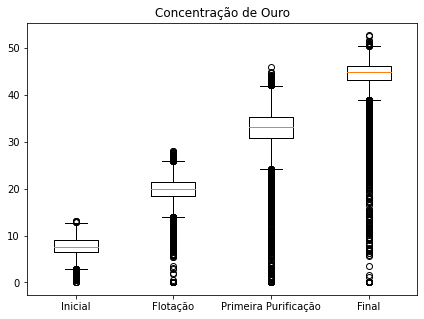

In [16]:
# Concentração de Ouro
build_metal_concentration_boxplot(df_gold_recovery_train, 'au')

A presença de outliers de Ouro vai aumentando conforme avançamos nas fases de purificação, especialmente outliers inferiores.<br><br>
Removendo os outliers da fase inicial verificaremos se eles estão influenciando na produção de outliers das outras fases

In [17]:
df_gold_recovery_train_no_outlier = remove_outliers(df_gold_recovery_train, 'rougher.input.feed_au')

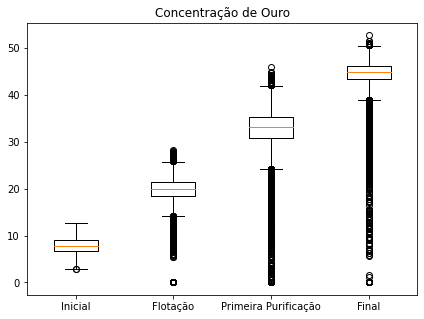

In [18]:
build_metal_concentration_boxplot(df_gold_recovery_train_no_outlier, 'au')

Ao remover os outliers da fase inicial verificamos que não há impacto na presença de outliers em outras fase, portanto deixaremos os outliers visto que não interfere nos resultados e teremos mais dados para trabalhar.

#### Prata

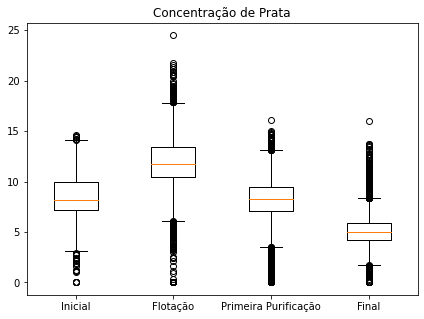

In [19]:
# Concentração de Prata
build_metal_concentration_boxplot(df_gold_recovery_train, 'ag')

A presença de outliers de Prata está mais distribuída que na amostra de Ouro, com leve predominância nos outliers inferiores, com exceção da última fase que possui mais outliers superiores.<br><br>
Removendo os outliers da fase inicial verificaremos se eles estão influenciando na produção de outliers das outras fases

In [20]:
df_gold_recovery_train_no_outlier = remove_outliers(df_gold_recovery_train, 'rougher.input.feed_ag')

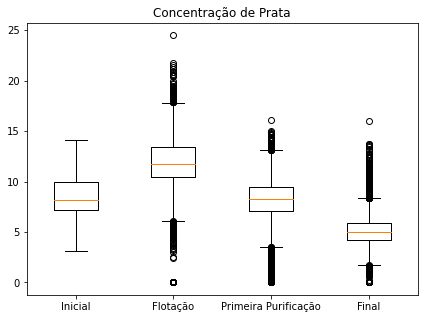

In [21]:
build_metal_concentration_boxplot(df_gold_recovery_train_no_outlier, 'ag')

Ao remover os outliers da fase inicial verificamos que não há impacto na presença de outliers em outras fase, portanto deixaremos os outliers visto que não interfere nos resultados e teremos mais dados para trabalhar.

#### Chumbo

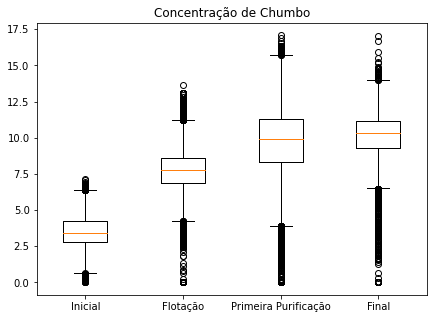

In [22]:
# Concentração de Chumbo
build_metal_concentration_boxplot(df_gold_recovery_train, 'pb')

A presença de outliers de Chumbo está mais distribuída que na amostra de Ouro, com predominância dos outliers inferiores, em todas as fases.<br><br>
Removendo os outliers da fase inicial verificaremos se eles estão influenciando na produção de outliers das outras fases

In [23]:
df_gold_recovery_train_no_outlier = remove_outliers(df_gold_recovery_train, 'rougher.input.feed_pb')

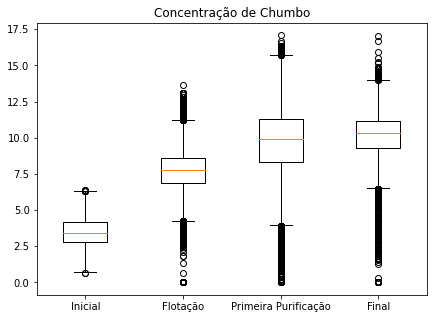

In [24]:
build_metal_concentration_boxplot(df_gold_recovery_train_no_outlier, 'pb')

Ao remover os outliers da fase inicial verificamos que não há impacto na presença de outliers em outras fase, portanto deixaremos os outliers visto que não interfere nos resultados e teremos mais dados para trabalhar.

### Compare as distribuições de tamanho de partícula de minério no conjunto de treinamento e no conjunto de teste. Se as distribuições variarem significativamente, a avaliação do modelo estará incorreta.

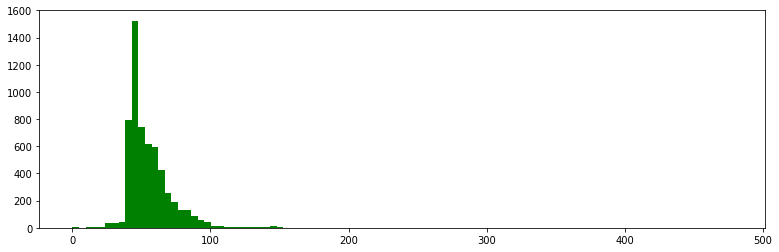

In [25]:
plt.figure(figsize=(13,4))
plt.hist(df_gold_recovery_test['rougher.input.feed_size'], 100, color='green')
plt.show()

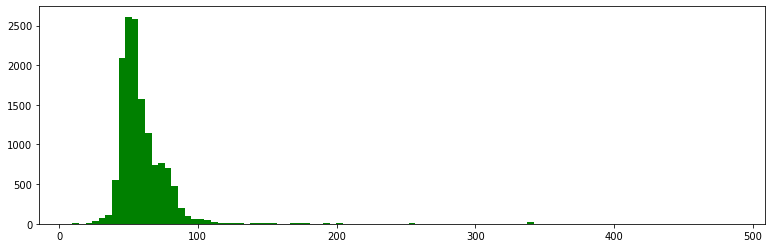

In [26]:
plt.figure(figsize=(13,4))
plt.hist(df_gold_recovery_train['rougher.input.feed_size'], 100, color='green')
plt.show()

A distribuição nos dois conjuntos não varia significativamente portanto a avaliação do modelo não parece estar incorreta

### Considere as concentrações totais de todas as substâncias em diferentes estágios: minério bruto, concentrado bruto e concentrado final. Você percebe algum valor anormal na distribuição total? Se você fizer isso, vale a pena remover esses valores de ambas as amostras? Descreva os resultados e elimine as anomalias.

In [27]:
def build_substance_concentration_distribution(df):
    
    # Utilizaremos as colunas que têm os valores de minério bruto, concentrado bruto e concentrado final
    cols = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']
    
    # Dicionário para utilizar os metais presentes e poder concatenar para formar os nomes das colunas
    substances = {'Ouro':'au', 'Prata':'ag', 'Chumbo':'pb'}
    
    # Ciclo para percorrer todas as colunas 
    for substance, symbol in substances.items():
        newcols = []
        for col in cols:
            newcols.append(col+symbol)
        
        # Plotando o gráfico
        fig, ax = plt.subplots(figsize =(7, 5))
        plt.title(f'Concentração de {substance}')
        plt.boxplot(df[newcols])
        ticks, labels = plt.xticks()
        plt.xticks(ticks, labels=['Minério Bruto', 'Concentrado Bruto', 'Concentrado Final'])

        plt.show()

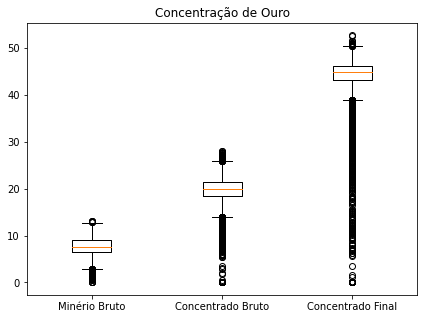

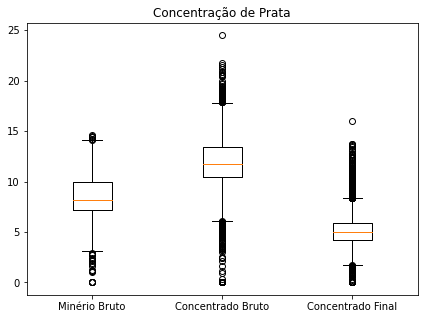

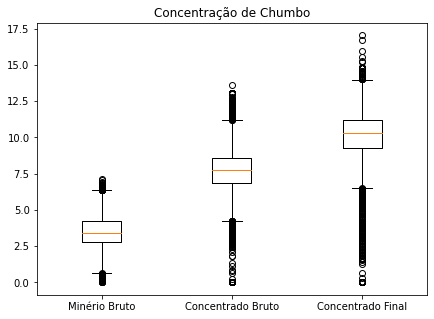

In [28]:
build_substance_concentration_distribution(df_gold_recovery_train)

In [30]:
# Preencher os valores nulos do Dataframe Completo com a mediana
newcols = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']
metals = ['au', 'ag', 'pb']

for col in newcols:
    for metal in metals:
        df_gold_recovery_full[col+metal].fillna(df_gold_recovery_full[col+metal].median(), inplace=True)

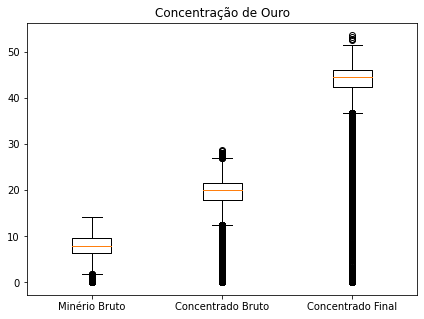

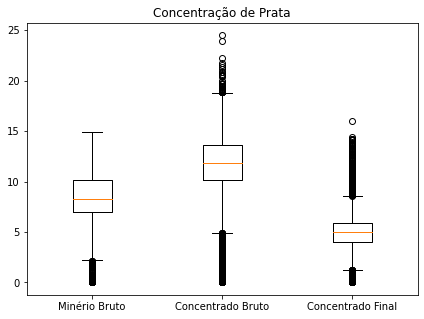

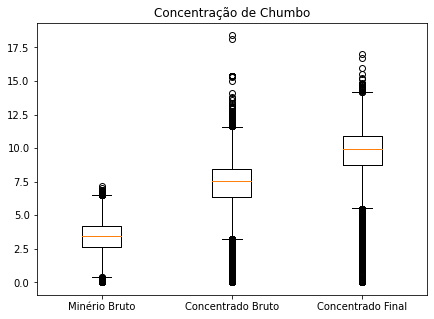

In [31]:
build_substance_concentration_distribution(df_gold_recovery_full)

Considerando o exposto no item 2.1, não removeremos as anomalias. Mas cabe notar que o Ouro e o Chumbo tem a tendência de possuir mais outliers inferiores e a prata mais outliers superiores.

## Construir modelo

### Escreva uma função para calcular o valor final sMAPE.

### Treine modelos diferentes. Avalie-os usando validação cruzada. Escolha o melhor modelo e teste-o usando a amostra de teste. Forneça resultados.
Use estas fórmulas para métricas de avaliação:<br>
<img src="sMAPE_formula.png">
<br>
<img src="sMAP_final.png">


#### Preparação dos dados para construção dos modelos

In [32]:
# Features do treinamento para prever o 'final.output.recovery'
columns_final_features = df_gold_recovery_test.columns.drop('date')

# Feature do treinamento para prever o 'rougher.output.recovery'
columns_rougher_features = [col for col in df_gold_recovery_train.columns if 'rougher.input' in col]

In [61]:
def sMAPE(predictions, target):
    predictions = pd.Series(predictions)
    n = len(predictions)
    summatory=0
    for i in range(0, n):
        summatory += (abs(target.iloc[i]-predictions.iloc[i]))/((abs(target.iloc[i]+predictions.iloc[i]))/2)
    value = (1/n)*summatory
    
    return value

In [34]:
def final_sMAP(rougher_sMAPE, final_sMAPE):
    return (0.25*rougher_sMAPE)+(0.75*final_sMAPE)

In [35]:
# Construir um Dataframe com o target do dataframe df_gold_recovery_test utilizando o df full

df_merged = pd.merge(df_gold_recovery_full, df_gold_recovery_test, left_on='date', right_on='date', how='inner')
df_gold_recovery_test_with_target = df_gold_recovery_full[df_gold_recovery_full['date'].isin(df_merged['date'])]

test_new_index = list(columns_final_features)
test_new_index.append('rougher.output.recovery')
test_new_index.append('final.output.recovery')

df_gold_recovery_test_with_target = df_gold_recovery_test_with_target[test_new_index]
df_gold_recovery_test_with_target.index = df_gold_recovery_test.index

In [36]:
# Preencher os valores nulos do target 'rougher.output.recovery' de df_gold_recovery_test
x = df_gold_recovery_test_with_target['rougher.output.recovery']
df_gold_recovery_test_with_target['rougher.output.recovery'] = x.fillna(x.median())
df_gold_recovery_test_with_target['rougher.output.recovery'].isna().sum()

0

In [37]:
# Excluir as linhas sem o target 'final.output.recovery'
df_gold_recovery_test_with_target.dropna(subset=['final.output.recovery'], inplace=True)

In [38]:
# conjunto de teste preenchido e agora com target
df_test_pp_with_target = df_test_pp.iloc[df_gold_recovery_test_with_target.index]
df_test_pp_with_target[['rougher.output.recovery', 'final.output.recovery']] = df_gold_recovery_test_with_target[['rougher.output.recovery', 'final.output.recovery']]

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### Funções para Validação Cruzada

In [39]:
#Função para fazer validação cruzada com série temporal
def sMAPE_cross_validation_time(df, features, target):
    tscv = TimeSeriesSplit()
    sMAPEs = []
    models = []
    
    for train_indexes, valid_indexes in tscv.split(df):
        features_train = features.iloc[train_indexes] 
        features_valid = features.iloc[valid_indexes]
        target_train = target.iloc[train_indexes]
        target_valid = target.iloc[valid_indexes]

        
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        
        sMAPEs.append(sMAPE(predictions_valid, target_valid))
        models.append(model)
    
    return models, sMAPEs
        

In [54]:
def sMAPE_cross_validation_time_random_forest(df, features, target):
    tscv = TimeSeriesSplit()
    sMAPEs = []
    models = []
    
    # Criar validação cruzada baseada no tempo
    for train_indexes, valid_indexes in tscv.split(df):
        features_train = features.iloc[train_indexes] 
        features_valid = features.iloc[valid_indexes]
        target_train = target.iloc[train_indexes]
        target_valid = target.iloc[valid_indexes]
            
            # Criar modelos de Random Forest com hiperparameter tuning para cada conjunto de tempo
        for i in range(1, 9, 2):
            best_sMAPE = 100
            best_model = None
                
            rf_model = RandomForestRegressor(max_depth=i, random_state=12345)
            rf_model.fit(features_train, target_train)
            predictions_valid = rf_model.predict(features_valid)
                
            value = sMAPE(predictions_valid, target_valid)
            if value < best_sMAPE:
                best_sMAPE = value
                best_model = rf_model
            
        sMAPEs.append(best_sMAPE)
        models.append(best_model)
            
    return models, sMAPEs

In [41]:
def final_sMAP_calc(df, features, target, rougher_features, rougher_target, function='Linear'):
    final_sMAPs = []
    
    if function == 'Linear':
        final_models, sMAPEs = sMAPE_cross_validation_time(df, features, target)
        rougher_models, rougher_sMAPEs = sMAPE_cross_validation_time(df, rougher_features, rougher_target)

        for rougher, final in zip(rougher_sMAPEs, sMAPEs):
            final_sMAPs.append(final_sMAP(rougher, final))
        
    elif function == 'RandomForest':
        final_models, sMAPEs = sMAPE_cross_validation_time_random_forest(df, features, target)
        rougher_models, rougher_sMAPEs = sMAPE_cross_validation_time_random_forest(df, 
                                                                                   rougher_features, rougher_target)

        for rougher, final in zip(rougher_sMAPEs, sMAPEs):
            final_sMAPs.append(final_sMAP(rougher, final))
    else:
        return print('Função não aplicável')
    
    return final_sMAPs
        

In [71]:
def print_results(results):
    for i in range(len(results)):
        print(f'O grupo {i+1} tem sMAPE de {results[i]:.2%}')
    results_mean = sum(results)/len(results)
    print(f'A média dos sMAPEs é de {results_mean:.2%}')

#### Conjunto de Treinamento

In [43]:
# Características e alvo de final
features = df_gold_recovery_train[columns_final_features]
target = df_gold_recovery_train['final.output.recovery']

In [44]:
# Características e alvo do minério bruto
rougher_features = df_gold_recovery_train[columns_rougher_features]
rougher_target = df_gold_recovery_train['rougher.output.recovery']

##### Regressão Linear

In [62]:
train_sMAPs = final_sMAP_calc(df_gold_recovery_train, features, target, rougher_features, rougher_target)
print(train_sMAPs)

[0.13795447086345633, 0.12909953741248084, 0.13479007851478633, 0.15618972472832363, 0.13966274285946137]


In [72]:
print_results(train_sMAPs)

O grupo 1 tem sMAPE de 13.80%
O grupo 2 tem sMAPE de 12.91%
O grupo 3 tem sMAPE de 13.48%
O grupo 4 tem sMAPE de 15.62%
O grupo 5 tem sMAPE de 13.97%
A média dos sMAPEs é de 13.95%


##### Floresta Aleatória

In [64]:
rf_train_sMAPs = final_sMAP_calc(df_gold_recovery_train, features, target, rougher_features, rougher_target, function='RandomForest')
print(rf_train_sMAPs)

[0.12168446391648098, 0.12848727567826254, 0.13642565520334532, 0.15364004006563378, 0.10810969064876566]


In [73]:
print_results(rf_train_sMAPs)

O grupo 1 tem sMAPE de 12.17%
O grupo 2 tem sMAPE de 12.85%
O grupo 3 tem sMAPE de 13.64%
O grupo 4 tem sMAPE de 15.36%
O grupo 5 tem sMAPE de 10.81%
A média dos sMAPEs é de 12.97%


#### Conjunto de Teste

In [66]:
# Características dos dados de df_gold_recovery_test
df_test_features = df_test_pp_with_target[columns_final_features]
df_test_rougher_features = df_test_pp_with_target[columns_rougher_features]

# Alvos dos dados de df_gold_recovery_test
df_test_target = df_test_pp_with_target['final.output.recovery']
df_test_rougher_target = df_test_pp_with_target['rougher.output.recovery']

##### Regressão Linear

In [67]:
test_sMAPs = final_sMAP_calc(df_test_pp_with_target, df_test_features, df_test_target, 
                             df_test_rougher_features, df_test_rougher_target)
print(test_sMAPs)

[0.3552201822723791, 0.09906167497263058, 0.17548133924904744, 0.12446471993337735, 0.13861361956574306]


In [74]:
print_results(test_sMAPs)

O grupo 1 tem sMAPE de 35.52%
O grupo 2 tem sMAPE de 9.91%
O grupo 3 tem sMAPE de 17.55%
O grupo 4 tem sMAPE de 12.45%
O grupo 5 tem sMAPE de 13.86%
A média dos sMAPEs é de 17.86%


##### Floresta Aleatória

In [69]:
rf_test_sMAPs = final_sMAP_calc(df_test_pp_with_target, df_test_features, df_test_target, 
                             df_test_rougher_features, df_test_rougher_target, function='RandomForest')
print(rf_test_sMAPs)

[0.20346537116326913, 0.0844455507504496, 0.13828694860792123, 0.10262466013413352, 0.14328844019888054]


In [75]:
print_results(rf_test_sMAPs)

O grupo 1 tem sMAPE de 20.35%
O grupo 2 tem sMAPE de 8.44%
O grupo 3 tem sMAPE de 13.83%
O grupo 4 tem sMAPE de 10.26%
O grupo 5 tem sMAPE de 14.33%
A média dos sMAPEs é de 13.44%


Os modelos de Regressão linear se mostraram piores que o de Floresta aleatória em ambos conjuntos, que por sua vez tem um erro médio percentual absoluto próximo de 13%, devido a quantidade de outliers, o modelo se comporta satisfatoriamente.